In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

# Grids and Coordinates

A (computational) grid in ESMs is a specification for indexing a selected set of (grid) points on the Earth. In GFDL numerical ocean models, the horizontal ocean grid is a set of 2D arrays $\{x_{ji},y_{ji}\}$  where each index pair $ij$ specifies a logically rectangular "grid cell" centered at longitude and lattitude coordinates $(x_{ji},y_{ji})$ (in degrees). This set is augmented by the corresponding finite-element "metrics" of the grid cells $\{dx_{ji}, dy_{ji}, da_{ji}, angle_{ji}\}$ corresponding to the lengths in $x$ and $y$ directions (meters), the cell area (meters squared) and the angle that the $dx$ makes with the lattitude circle at that point.  

The goal of this tool set is to generate such a grid that covers the world oceans for a given nominal resolution e.g., $\delta = x_{10}-x_{00}$ at the equator.   

For a properly small region of the Earth (hence flat), this could easily be accomplished by a regular, rectangular coordinate patch, namely $x_{ji} = i \delta, y_{ji} = j \delta, dx=dy= \delta, da=\delta^2, angle=0$. 
For a global curved surface like that of Earth however it is topologically impossible to come up with a single, everywhere non-singular coordinate patch that covers the whole surface. We must hence resort to using multiple (at least 2) coordinate patches for the globe. The choice of the number and shape of these patches usually come from the restrictions of the numerical model that is using the grid (e.g., removing the singularity of the lat-lon grid at the northern polar ocean), or the choice of the investigators that want to put more resolutions in some parts of the model.  

The preferred horizontal grid in the GFDL Modular Ocean Models (MOM6) is composed of 4 coordinate patches (stiched together) as follows:
1. A Mercator projection grid spanning the equator 
2. A Murray northern bipolar cap
3. A regular spherical (lat-lon) grid spanning the southern ocean
4. A regular spherical sothern cap with an optional displaced south pole


# Constructing a Grid on Sphere by Projection

A general mathematical remark is helpful here. We can construct a grid on a sphere via a number of projections. A projection is an invertible smooth map $P$ from  the surface of the sphere onto a subset $T$ of the Euclidian plane and can be expressed by

\begin{equation}
(\xi_1,\xi_2) = P(\lambda, \phi) 
\end{equation}

Now, if we can make a coordinate patch for the target set $T$ such that all image points for our grid have integer coordinates $(\xi_1,\xi_2)=(i,j)$ then we can apply the inverse map $P^{-1}$ to this set (reproject) to obtain a grid of $(\lambda_{ji}, \phi_{ji})$ on the sphere.

Among the simplest of these projections are the "spherical projections" $(\xi_1,\xi_2) = (R\lambda,R\phi)$ and $(\xi_1,\xi_2) = (R\lambda,R \sin(\phi))$ which give rise to the familiar regular lat-lon grids on the sphere. The Mercator projection described below is also a "spherical projection" with some additional features that are helpful to oceanographers.   


# Mercator Projection

For a given point on a sphere of radius $R$ with $(longitude,latitude) = (\lambda, \phi)$ the (isotropic) Mercator projection is defined by:  
\begin{equation}
\xi_2 = M(\phi) = R \ln \left[ 1+\sin\phi \over \cos\phi \right].\label{eq:yM} 
\end{equation}
The corresponding inverse function can be written as:
\begin{equation}
\phi = M^{-1}(\xi_2) = \tan^{-1}\left(\sinh(\xi_2/R)\right).\label{eq:phiM}
\end{equation}


Here $R$ is the radius of the "globe" representing the Earth and is determined by the scale of the projection. E.g., to project the Earth surface to a rectangular map of width $L$ one can use a "principal scale" of $L/(2\pi a_{E})$ ($a_{E})$ being radius of the isotropic Earth), which corresponds to a "globe" of radius $R=L/2\pi$. Note that  this function does not describe the geometrical projection (as of light rays onto a screen) from the centre of the globe to the cylinder, which is only one of an unlimited number of ways to conceptually project a cylindrical map.

These are one of a few equivalent analytic forms of the projection function. For an overview and more information refer to [the wikipedia article on Mercator Projection](https://en.wikipedia.org/wiki/Mercator_projection).


## Mercator Grid Specification


Suppose we want to generate an isotropic Mercator grid corresponding to a nominal resolution of $\Delta \lambda_{n}$ at the equator (e.g., 1/4 degree). Here are the defining parameters of our Mercator super-grid (a grid with twice the desired resolution that is used in ocean models):

0. Like other projection constructions, the supergrid should come from the re-projection of a planar grid patch of integer coordinates. 
1. The super-grid cell resolution in longitude direction should be $\Delta \lambda = \Delta \lambda_{n} / 2$ (e.g., 1/8).  
2. The super-grid cell resolution in latitude  direction should be the same as in longitude direction at the equator $\Delta \phi(\phi=0) = \Delta \lambda$. 
3. With the resolution being fixed by the above two, we should specify the nominal extent of the grid to be from $\tilde{\Phi}_s$ to $\tilde{\Phi}_n$.

To achieve these we must:
  
0. set $(\xi_1,\xi_2) = (i,j)$ and hence  $\Delta \xi_1 = \Delta \xi_2 =1$  
1. partition the equator to $N_i$ intervals such that $\Delta \lambda = {360\over N_i}$ (e.g., 2880),
\begin{equation}
N_i = 2 {360 \over \Delta \lambda_{n}}.
\end{equation}

2. calculate $\Delta y$ given $\Delta \phi$ using equation \eqref{eq:phiM}:
\begin{equation*}
\Delta \phi = \Delta \xi_2  ({d\phi \over d\xi_2 }) |_{\xi_2 =0} = \Delta\xi_2 {1\over R} {\cosh(\xi_2 /R) \over 1+\sinh^2(\xi_2 /R)} |_{\xi_2 =0} = {\Delta \xi_2 \over R}
\end{equation*}
    
 The above conditions fix the value of the projection scale $R$ as follows:
\begin{equation}
R = {\Delta \xi_2 \over \Delta \phi} |_{\xi_2 =0} = {\Delta \xi_2 \over \Delta \lambda}|_{\xi_2 =0} = {N_i \over 2\pi}
\end{equation}

 This result holds for any "spherical projection", in fact this is my definition of "spherical projection". 
    
3. Generally the nominal extents $\tilde{\Phi}_s$ and $\tilde{\Phi}_n$ do not produce integer values for $\xi_2$ from equation \eqref{eq:yM}. Instead, we shall calculate the nearest integer values $j_s = {int} (M(\tilde{\Phi}_s))$ and $j_n = {int} (M(\tilde{\Phi}_n))$ and use them as the grid extents in the j-direction. The actual lattitudinal extents of the grid are then determined from \eqref{eq:phiM} to be $M^{-1}(j_s)$ and $M^{-1}(j_n)$. In our tool we also shift the grid indices such that $j_s=0$.


# Bipolar Northern Cap Projection

Here we construct the bipolar northern cap grid using a geometric method different from but inspired by  [Murray's 1996 paper](https://doi.org/10.1006/jcph.1996.0136) [1].

At the heart of the algorithm are again  a projection from sphere onto Euclidian plane, coordinate the image by integers and finally reproject back to the sphere. In the present case the useful projection is streographic.  

It is helpful to first look at the end product to get a geometrical intuition. We want to end up with a coordinate system for the northern ocean that is not "singular" at the North pole. Figure below shows one such grid consructed in  [Murray's 1996 paper](https://doi.org/10.1006/jcph.1996.0136). It has two "poles" but they are moved away from the ocean and located on land.

![Murray's bipolar grid](extras/tripolar.jpeg)


There are a few ways to construct such a grid, here we describe one (very similar to the idea of a [Wulf net](https://en.wikipedia.org/wiki/Stereographic_projection)). 

![Wulf net](extras/Wulffnet.png)

![Wulf net construction](extras/Wulffnet_construct.png)


Consider a globe sphere of radius $r$ with the regular lon,lat grid but the grid lines rotated by 90 degrees around an axis that crosses the equator at the longitude $\lambda_P+90$, where $\lambda_P$ is the desired longitude of the displaced bi-poles (-300 in MIDAS construction). We denote these set of grid lines by $\Lambda_c$ and  $\Phi_c$. Note that this coordinate patch has two opposing poles at the equator (see the right part of the figure above and imagine the North pole is at the antipole of point C).


First we do a stereographic projection $P_r$ of the these two sets of circles onto a plane tangent at the North pole. This results in a polar coordinate patch on that plane (see the left part of the figure above). 

Next we do an inverse stereographic projection $P_R^{-1}$ of these polar coordinate curves back on a sphere with a larger radius $R$ to relocate the poles to the desired latitude of the bipolar grid $\phi_P$. We denote these sets by $\Lambda_s$ and  $\Phi_s$, these form the desired orthogonal bipolar coordinate patch for the North cap.


## Grid Construction

-  globe sphere vs. earth sphere
-  ($\lambda_g$,$\phi_g$): geographical longitude and latitude of a point on a globe sphere
-  ($\lambda_c$,$\phi_c$): intermediate coordinate patch on the globe sphere (rotated-lat-lon with poles on Equator) 
-  ($\lambda_s$,$\phi_s$): final curvilinear coordinate patch after streographic projection and re-projection  
-  $\phi_{bp}$ :    the latitude  of the bounding parallel of bipolar grid (the bipolar fold)
-  $\lambda_{bp}$ : the longitude of the split bipole(s).


*  Start with a simple lon,lat coordinate patch covering the Northern globe hemisphere:

\begin{align}
\lambda_g &= \lambda_{bp} + i \frac{360}{N_i} \\
\phi_g    &= j \frac{90}{N_j} \label{eq:phig}
\end{align}

*  Next consider the following two sets of circles $\Lambda_c$ and $\Phi_c$ on the globe sphere: 
  * $\Lambda_c$ : The set of great circles with the common axis that crosses the equator at longitude $\lambda_P$. Note that these are NOT the geographical meridians, but their 90 degrees rotated images. These circles are formed by the intersection of planes through origin with unit normal vectors ${\bf u} = ( 0,\sin\phi_g , \cos\phi_g)$ and the globe, where $\phi_g$ is the angle between ${\bf u}$ and y axis assuming we set $x$ axis in the direction of $\lambda_{bp}$. Hence they obey ${\bf u} {\bf .}  (\cos\phi \cos(\lambda-\lambda_{bp}),\cos\phi \sin(\lambda-\lambda_{bp}),\sin\phi )=0$ which gives: 
\begin{equation*}  
\tan\phi=-\tan\phi_g \sin(\lambda-\lambda_{bp}).
\end{equation*}
  
   * $\Phi_c$ : The set of parallel circles with the same axis as above. Note that these are NOT the geographical parallels, but their 90 degrees rotated images.  
These circles are formed by the intersection of planes perpendicular to the axis of the great circles above with unit normal vectors ${\bf u} = ( 1, 0, 0)$ and the globe, we set $x$ axis in the direction of $\lambda_P$. Hence they obey:

\begin{equation*} 
\cos\phi \cos(\lambda-\lambda_P) = \cos(\lambda_g-\lambda_{bp}).
\end{equation*}

*  The curvilinear coordinate patch $(\lambda_c,\phi_c)$ on the globe sphere is obtained by solving the above two equations simultaneously, yielding: 

\begin{align}
\frac{\sin(\lambda_c-\lambda_{bp})}{\tan\phi_c} &= -\frac{1}{\tan\phi_g}      \equiv \beta  \label{eq:beta} \\
{\cos(\lambda_c-\lambda_{bp}) \cos\phi_c}       &=  \cos(\lambda_g-\lambda_{bp})\equiv  \alpha \label{eq:alpha}
\end{align}

  which give:

\begin{align}
 \phi_c &= \sin^{-1}\left[ \left(\frac{1-\alpha^2}{1+\beta^2}\right)^{1/2} \right] \label{eq:phic} \\
 \lambda_c-90 &= \sin^{-1}\left[ \left(\beta^2\frac{1-\alpha^2}{\alpha^2+\beta^2} \right)^{1/2} \right] \label{eq:lamc}
\end{align}

  Note that because of the square roots in the above equations the signs have to be chosen so that the solution remains continuous.

* Finally to achieve the stereographic projection/re-projection (in the spirit of Murray96) we only need to observe a simple relation between the angels in the geometric construction (this is the same as Murray96 equations 1 and 2): 

\begin{align}
\tan(\frac{(90-\phi_s)}{2}) &= \tan(\frac{(90-\phi_{bp})}{2}) \tan(\frac{(90-\phi_c)}{2})\label{eq:geometry}\\
\lambda_s &= \lambda_c
\end{align}

  and so:

\begin{align}
\phi_s &= 90 - 2 \tan^{-1}\left( r_P \tan(\frac{(90-\phi_c)}{2}) \right) ; \ \ r_P \equiv \tan(\frac{(90-\phi_{bp})}{2}) \label{eq:phis} \\
\lambda_s &= \lambda_c
\end{align}

## Additional degree of freedom in the grid  construction

There is an additional degree of freedom in the bipolar grid construction that if ignored would cause a difference with Murray96 grid. We can (and perhaps should) construct the initial northern globe grid latitudes $\phi_g$ not with a uniform but with a variable resolution such that the final projected/reprojected grid $\phi_s$ has the desired uniform resolution along the "symmetry meridian" of longitude $\lambda_{bp}-90$. I.e., we want

\begin{align}
\Delta \phi_s(\lambda_c=\lambda_P-90) = Constant = \frac{90-\phi_{bp}}{N_j}. 
\end{align}

We can find the required $\phi_g$ that produces this by inverting equation\eqref{eq:phis}:

\begin{align}
\phi_c &= 90 - 2 \tan^{-1}\left(\frac{1}{r_P} \tan(\frac{(90-\phi_s)}{2})  \right). \label{eq:inversestereog}
\end{align}

and noting that according to equation\eqref{eq:beta} $\phi_c=\phi_g$ along the symmetry meridian $\lambda_c=\lambda_{bp}-90$.

To summarize these transformations schematically:

\begin{align}
(x,y,z)&\xrightarrow{\text{Spherical latlon}} (\lambda^0_g,\phi^0_g) \\
       &\ \xrightarrow{\text{Inverse Stereographic}} (\lambda_g,\phi_g) = (\lambda^0_g,P^{-1}(\phi^0_g))  \\          &\ \ \xrightarrow{\text{Curvilinear}} (\lambda_c,\phi_c) \\
       &\ \ \ \xrightarrow{\text{Stereographic}} (\lambda_s,\phi_s) = (\lambda_c,P(\phi_c))
\end{align}


## Algorithm

*  Generate a mesh using simple lat-lon grid covering the cap
\begin{align}
(\lambda_g)_{ij} &= \lambda_{bp} + i \frac{360}{N_i} \\
(\phi_g^0)_{ij}  &= \phi_{bp} + j \frac{90 - \phi_{bp}}{N_j} \\
(\phi_g)_{ij}    &= 90 - 2 \tan^{-1}\left(\frac{1}{r_P} \tan(\frac{(90-(\phi_g^0)_j)}{2})  \right)
\end{align}

* Generate the mesh for $(\lambda_c)_{ij}$ and $(\phi_c)_{ij}$ using equations \eqref{eq:alpha} and \eqref{eq:beta}. Note that we should shift the $(\lambda_c)_{ij}$ by multiples of $\pi$ to be continuous with $(\lambda_g)_{ij}$ along the Equator. 

* Generate the mesh for $(\lambda_s)_{ij}$ and $(\phi_s)_{ij}$ using equations \eqref{eq:phis}.


# Generating a southern cap displaced pole grid

Here we present the algorithm and code for generating a compute grid for the Antarctic region with the south pole displaced by a given amount. The reason for displacing the pole is to map it as far as possible from the two biggest ice shelves on the continent (__[Ross and Ronne](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Antarctica.svg/907px-Antarctica.svg.png)__) to have a viable compute grid over them. We generate the grid starting from a usual lat-lon grid on the sphere followed by a series of transformations from the spherical surface of the Earth to a tangent plane at the south pole [2][3]. Particularly the displacement of the pole is accomplished via a conformal mapping in the tangent plane [4]. 


## Grid Parameters

-  $\phi_{SO}$:   ending latitude of the southern ocean grid
-  $\phi_{join}$: starting latitude of the antarctic cap grid (the join). Here we assume $\phi_{join}=\phi_{SO}$
-  $\lambda_{dp}$: longitude of the displaced pole
-  $\phi_{dp}$:  the latitude of the displaced pole  
-  $r_{dp}$:     the fractional distance of the displaced pole from the geographic pole in units of $\tan(90+\phi_{join})$ 



## Algorithm

-  Generate a regular lat-lon grid with desired resolution covering the Earth south of $\phi_{join} = \phi_{SO}$ , $(\lambda,\phi)$ .
-  Project the lat-lon grid to a plane tangent at the south pole (simple gnomonic projection)(not conformal) to planar polar coordinates:

\begin{align}
r &= R_E \tan(90+\phi) \\
\theta &= \lambda-\lambda_p
\end{align}

-  Rescale $r$ so that the parallel at  $\phi_{join}$ maps to the unit circle

\begin{align}
r = \tan(90+\phi)/r_{join} ;\ \ r_{join}\equiv\tan(90+\phi_{join}) \\
\end{align}

-  Use the inverse conformal map to transform $\theta$ so that the angular resolution at the unit circle in $w$-plane (see the next step) matches the corresponding resolution in $z$-plane (which matches the longitudinal resolution at the joint) :

\begin{align}
z_0 &= r_{dp} e^{i\lambda_p} \\
e^{i\theta'} &= w^{-1}(e^{i\theta}) = \frac{e^{i\theta}-z_0}{1+z_0^* e^{i\theta}}
\end{align}

-  Define

\begin{align}
z=r e^{i\theta'}
\end{align}

-  Do a conformal transformation to map the unit disk to a unit disk with a displaced center:

\begin{align}
w = \frac{z+z_0}{1+z_0^* z}
\end{align}

-  Project back to the sphere tangent at the geographical south pole to form the desired curvilinear coordinates:

\begin{align}
\lambda_c &= \arg(w)\\
\phi_c &= \tan^{-1}\left( |w| r_{join} \right) - 90
\end{align}


# Grid Metrics

We can generate the "metrics" by analytical manipulations. The length of a curve which is determined by integrating the infinitesimal length $ds$ along the curve is independent of the coordinates. This statement determines the "metric" tensor $g$ of the coordinates:

\begin{align}
ds^2 = \sum_{\mu,\nu} g^{\mu\nu} d\xi_\mu d\xi_\nu
\end{align}

In this writing $\mu$ and $\nu$ range over $1,2,3$, but the above formula is much more general than that.
For a Cartesian coordinate $g_{\mu\nu} = \delta_{\mu,\nu}$ and this is simply the Eucldian length $dx_1^2+dx_2^2+dx_3^2 = dx^2+dy^2+dz^2$. For a general orthogonal coordinate system such as $(\lambda_s,\phi_s)$ the metric is diagonal and is sometimes denoted by a set of metric coefficents $h$:

\begin{align}
ds^2 = \sum_{\mu} g^{\mu\mu} (d\xi_\mu)^2 \equiv \sum_{\mu} (h_\mu)^{-2} (d\xi_\mu)^2
\end{align}

Note that in our case the new coordinates are the indexes $(I,J)$ (captalized to avoid confusion with their descrete values $i,j$) and not $(\lambda_s,\phi_s)$! So, starting from the Cartesian coordinates $(x_1,x_2,x_3)$ and using the chain rule we get:


\begin{align}
ds^2 &= \sum_\mu dx_\mu^2 \nonumber \\
&=  \sum_\mu \left( \frac{\partial x_\mu}{\partial I} dI + \frac{\partial x_\mu}{\partial J} dJ  \right) ^2 \nonumber \\
&=  \sum_\mu \left[ \left( \frac{\partial x_\mu}{\partial \lambda_s} \frac{\partial \lambda_s}{\partial I} + \frac{\partial x_\mu}{\partial \phi_s} \frac{\partial \phi_s}{\partial I} \right) dI + \left( I \rightarrow J \right) dJ  \right]^2 
\end{align}

We can obtain formulas for $h$'s by considering curves along new coordinates:

\begin{align}
h_I^{-2} \equiv ds^2(dJ=0) = dI^2 \sum_\mu \left[ ( \frac{\partial x_\mu}{\partial \lambda_s} )^2 ( \frac{\partial \lambda_s}{\partial I} )^2 + ( \frac{\partial x_\mu}{\partial \phi_s} )^2 ( \frac{\partial \phi_s}{\partial I} )^2 + cross term \right]
\end{align}

Cross terms are generally zero if the new coordinates are orthogonal. We can easily verify this for  spherical lat-lon grids:

\begin{align}
x_1 &= x=\cos(\phi_s)\cos(\lambda_s) \nonumber \\
x_2 &= y=\cos(\phi_s)\sin(\lambda_s) \nonumber \\
x_3 &= z=\sin(\phi_s)
\end{align}

\begin{align}
cross term &= 2\sum_\mu()()()() = 2 (\frac{\partial  \lambda_s}{\partial I}) (\frac{\partial  \phi_s}{\partial I}) \left[ \sum_\mu (\frac{\partial x_\mu}{\partial \lambda_s}) (\frac{\partial x_\mu}{\partial \phi_s})\right] \nonumber \\
&= 2 (\frac{\partial  \lambda_s}{\partial I}) (\frac{\partial  \phi_s}{\partial I}) \left[ \cos(\phi_s)\sin(\lambda_s)\sin(\phi_s)\cos(\lambda_s) - \cos(\phi_s)\cos(\lambda_s)\sin(\phi_s)\sin(\lambda_s) \right]
&= 0
\end{align}

So, the metrics coefficients are:

\begin{align}
ds^2(dJ=0) = h_I^{-2} &= dI^2 \left[ ( \frac{\partial \lambda_s}{\partial I} )^2 \left( \cos^2(\phi_s)\sin^2(\lambda_s) + \cos^2(\phi_s)\cos^2(\lambda_s) + 0 \right) + ( \frac{\partial \phi_s}{\partial I} )^2 \left( \sin^2(\phi_s)\cos^2(\lambda_s) +\sin^2(\phi_s)\sin^2(\lambda_s) + \cos^2(\phi_s) \right) \right] \nonumber \\
 &= dI^2 \left[ ( \frac{\partial \lambda_s}{\partial I} )^2 \cos^2(\phi_s) + ( \frac{\partial \phi_s}{\partial I} )^2 \right] \\
ds^2(dI=0) = h_J^{-2} &= dJ^2 \left[ I \rightarrow J \right] \nonumber \\
 &= dJ^2 \left[ ( \frac{\partial \lambda_s}{\partial J} )^2 \cos^2(\phi_s) + ( \frac{\partial \phi_s}{\partial J} )^2 \right]
\end{align}

## Metrics Coefficients

### Spherical Grids

For a spherical lat-lon grid we obtain the familiar form:

\begin{align}
h_I^{-1} &= dI \frac{\partial \lambda}{\partial I} \cos(\phi) =  \delta\lambda \cos(\phi)
h_J^{-1} &= dJ \frac{\partial \phi}{\partial J}  = \delta\phi
\end{align}

where $\delta\lambda$ amd $\delta\phi$ are simply the longitude and latitude resolution of the grid. 

Note that the same formulas applies for our Mercator grid construction above. 

### Bipolar Cap Grid

Starting with the grid construction equation for the bipolar cap \eqref{eq:phis} and applying the chain rule we can calculate the terms one by one:
\begin{align}
\frac{\partial \lambda_s}{\partial I} &= \frac{\partial \lambda_c}{\partial I} \nonumber \\
&= \frac{\partial \lambda_c}{\partial \lambda_g} \frac{\partial \lambda_g}{\partial \lambda^0_g} \frac{\partial \lambda^0_g}{\partial I} + \frac{\partial \lambda_c}{\partial \phi_g} \frac{\partial \phi_g}{\partial \phi^0_g} \frac{\partial \phi^0_g}{\partial I} \nonumber \\
&= \frac{\partial \lambda_c}{\partial \lambda_g} \frac{\partial \lambda^0_g}{\partial I}   
\end{align}

Similarly

\begin{align}
\frac{\partial \phi_s}{\partial I} = \frac{\partial \phi_s}{\partial \phi_c} \frac{\partial \phi_c}{\partial \lambda_g} \frac{\partial \lambda^0_g}{\partial I} 
\end{align}

\begin{align}
\frac{\partial \lambda_s}{\partial J} = \frac{\partial \lambda_c}{\partial \phi_g} \frac{\partial \phi_g}{\partial \phi^0_g} \frac{\partial \lambda^0_g}{\partial J} 
\end{align}

\begin{align}
\frac{\partial \phi_s}{\partial J} = \frac{\partial \phi_s}{\partial \phi_c}  \frac{\partial \phi_c}{\partial \phi_g} \frac{\partial \phi_g}{\partial \phi^0_g} \frac{\partial \phi^0_g}{\partial J} 
\end{align}




Now by brute force differentiation of the curvilinear transformation formulas equations \eqref{eq:phic},\eqref{eq:lamc} we get

\begin{align}
(\frac{\partial \lambda_c}{\partial \lambda_g})^2 = \frac{1+\beta^{-2}}{(1+\alpha^2\beta^{-2})^2}
\end{align}


\begin{align}
(\frac{\partial \lambda_c}{\partial \phi_g})^2 = \frac{\alpha^2(1-\alpha^2)\beta^{-2}(1+\beta^{-2})}{(1+\alpha^2\beta^{-2})^2}
\end{align}

\begin{align}
(\frac{\partial \phi_c}{\partial \lambda_g})^2 = \frac{\alpha^2 \beta^{-2}}{1+\alpha^2\beta^{-2}}
\end{align}

\begin{align}
(\frac{\partial \phi_c}{\partial \phi_g})^2 = \frac{1-\alpha^2}{1+\alpha^2\beta^{-2}}
\end{align}



And similarly differentiation of the stereographic transformation formula equations \eqref{eq:phis},\eqref{eq:inversestereog} yield:

\begin{align}
M^{-1} \equiv \frac{\partial \phi_s}{\partial \phi_c} &= r_P \frac{1+\tan^2(\chi_c/2)}{1+r^2_P\tan^2(\chi_c/2)} ; \ \ \chi_c \equiv 90-\phi_c \nonumber \\
N \equiv \left(\frac{\partial \phi_g}{\partial \phi^0_g} \right)^{-1} &= r_P \frac{1+\tan^2(\chi_g/2)}{1+r^2_P\tan^2(\chi_g/2)}; \ \ \chi_g \equiv 90-\phi_g
\end{align}

We note that

\begin{align}
\frac{\partial \lambda^0_g}{\partial I} = 2\pi/N_i
\frac{\partial \phi^0_g}{\partial J} = (90-\phi_{bp})/N_j
\end{align}

Putting it all together we finally obtain the metric terms

\begin{align}
h^{-2}_I &= \left[ \cos^2(\phi_s) \frac{1+\beta^{-2}}{(1+\alpha^2\beta^{-2})^2} + M^{-2}  \frac{\alpha^2 \beta^{-2}}{1+\alpha^2\beta^{-2}}\right] \left( \frac{2\pi}{N_i} \right)^2 \\
h^{-2}_J &= \left[ \cos^2(\phi_s) N^{-2} \frac{\alpha^2(1-\alpha^2)\beta^{-2}(1+\beta^{-2})}{(1+\alpha^2\beta^{-2})^2} +  M^{-2}N^{-2} \frac{1-\alpha^2}{1+\alpha^2\beta^{-2}} \right] \left( \frac{\pi/2-\phi_{bp}}{N_j} \right)^2 
\end{align}

The value of the metric tensor is that it can yield the infinitesimal length along coordinate curves. Noting that $dI=dJ=1$ for a grid element we have:

\begin{align}
i-direction\  length\  element &= \sqrt{ds^2(dI=1,dJ=0)} = h^{-1}_I \\
j-direction\  length\  element &= \sqrt{ds^2(dI=0,dJ=1)} = h^{-1}_J \\
grid-cell\ \ \ area\  element &= h^{-1}_I . h^{-1}_J
\end{align}

### Displaced Pole Grid

Unfortunately we could not obtain a closed form for the metrics coefficients for the displaced pole grid and had to resort to a numerical approximation for them.

## Finite Element Metrics

Above we obtained the formulas for \underline{infinitesimal} metrics coefficients, $h$. To get the finite element lengths (or areas) for our model grid we would need to integrate these infinitesimal lengths (areas) over each grid cell. We can do this analytically for the spherical grids, but not for the rest. So, for bipolar and displaced pole grids we do it by a numerical quadrature method ([Gauss–Lobatto](https://en.wikipedia.org/wiki/Gaussian_quadrature)[5]).  


# Appendix A

## Murray 96 Comparison

Murray's grid is based on the same idea of projecting and re-projecting from globe sphere to plane to Earth sphere, with the difference that he has the plane tangent at the equator at the longitude of the desired final bipoles. Hence he has an extra 90 degrees rotation to deal with to bring the grid onto the Northern cap. This is rather complicated since it exchanges the roles of latitude and longitude at some point in the construction which is not totally explained in his paper. Otherwise the form of the constructing formulas are equivalent to the ones above in spirit , but left their interpretation is not clear. We copy Murray 96 formulas below for comparison. 

Murray96 equations (1) and (2) are 

\begin{align}
Murray1:\ \ \ \ &\tan(\frac{\chi_s}{2}) = r_P \tan(\frac{\chi_c}{2})\\
Murray2:\ \ \ \ &r_P  = \tan(\frac{\chi_P}{2}) 
\end{align}

This is a geometric property of a stereographic projection of sphere onto a tangent plane and then projecting back onto a sphere of larger radius tangent at the same point to the plane. These two sphere have a common axis $RQ$ passing through their centers and the tangent point and these are simple the relations between three spherical angels; 1)  $\chi_P$ is the spherical angle between $RQ$ and the line joining the center of the (larger) earth sphere to the north pole of the (smaller) globe sphere, 2) $\chi_c$ is the spherical angle between $RQ$ and the line joining the center of the globe sphere to a given point $X$ on that sphere, 3) $\chi_s$ is the spherical angle between $RQ$ and the line joining the center of the Earth sphere to the re-pojected image of the point $X$ on that sphere (refer to FIG.3 of Murray96).

Murray96 equations (5) and (6) for generating the curvilinear grid are 

\begin{align}
Murray5a:\ \ \ \ \lambda_s &= \lambda_0 + 90 - atan2(sin\lambda_c,\tan\phi_c)\\
Murray5b:\ \ \ \ \phi_s &= 90 - 2\tan^{-1}\left( r_p \tan(\frac{\chi_c}{2}) \right) \\
Murray6:\ \ \ \ \chi_c &= \cos^{-1}\left( \cos\lambda_c \cos\phi_c \right) 
\end{align}


The above equation\eqref{eq:phis} would be identical to Murray's Eq(5b) if we assume $\chi_c = 90-\phi_c$. But then Murray's Eq(6) $\cos\chi_c = \cos\lambda_c \cos\phi_c$, would be in conflict with that assumption (relates $\phi_c$ to $\lambda_c$)! On the other hand Murray's Eq(6) is somewhat similar to the equation \eqref{eq:alpha} above if we assume $\chi_c=\lambda_g-\lambda_P$, which would then be in apparent conflict with equation\eqref{eq:phis} above. 

Murray's Eq(5a) is similar to equation\eqref{eq:beta} above if we assume that $\lambda_s-\lambda_P=\phi_g$, which is again in apparent conflict with all other equations.

Moreover in MIDAS (and FMS) implementation $\lambda_c$ and $phi_c$ are derived from $\phi_g$ and $\lambda_g$ respectively, contrary to the intuition ($\lambda_c$ is derived via solving Murray's Eq(5a) for $\lambda_c$ at $\phi_c=0$ given $\lambda_s=\phi_g$ and $\phi_c$ is set to $90-\lambda_g$.) 

All these conflicts point to a subtle switching of the roles of latitude and longitude at the connection line in the transformation defined in Murray which he mentions only in passing at section 2.2. 

# References

[1] [Explicit Generation of Orthogonal Grids for Ocean Models, Ross J.Murray, Journal of Computational Physics
Volume 126, Issue 2, July 1996, Pages 251-273](https://doi.org/10.1006/jcph.1996.0136)

[2] [Roberts, J. L., Heil, P., Murray, R. J., Holloway, D. S., and Bindoff,
N. L.: Pole relocation for an orthogonal grid: An analytic method,
Ocean Model., 12, 16–31, doi:10.1016/j.ocemod.2005.03.004,
2006.](https://doi.org/10.1016/j.ocemod.2005.03.004)

[3] [Xu, S., Wang, B., and Liu, J.: On the use of Schwarz–Christoffel conformal mappings to the grid generation for global ocean models, Geosci. Model Dev., 8, 3471-3485, https://doi.org/10.5194/gmd-8-3471-2015, 2015.](https://doi.org/10.5194/gmd-8-3471-2015)

[4] Basic Complex Analysis, J.E. Marsden, M.J. Hoffman, 2nd Edition, p.355.

[5] https://en.wikipedia.org/wiki/Gaussian_quadrature

## Explore the Grid Generation Tool

This tool can be called to generate a grid with nominal resolution of 1/4 degrees by the following command line:

ocean_grid_generator.py -f tripolar_res4_areacorrected.nc -r 4 --south_cutoff_row 81

You can also explore the tool by the following jupyter notebook.

In [2]:
import imp  
import numpypi_series as np
import ocean_grid_generator as ogg
import matplotlib.pyplot as plt
%matplotlib inline
import math

import numpy as np
PI_180 = np.pi/180.

In [3]:
### Specify the grid properties
degree_resolution_inverse=4 # This is the inverse of the nominal resolution in degrees (8 for 1/8 degrees)
refineR=degree_resolution_inverse
refineS=2 # factor 2 is for supergrid
lenlon=360  # global longitude range
Ni=int(refineR*refineS* lenlon) #Number of longitude partitions Eq(5) 

#Mercator grid nominal extents 
#These values were chosen to generate a grid very close to the MIDAS grid for 1/4 degree OMIP
phi_s_Merc, phi_n_Merc = -66.85954725, 64.05895973
lon0=-300. #Starting longitude (also the longitude of the Northern bipoles) 
           #Why this particular value? I think it's chosen so that North America will be at the center of the map!

In [4]:
#Reload the grid generating tool (in case you change something in the tool and want it to take effect in this notebook)
imp.reload(ogg) 
#
#Generate the Mercator grid 
#
lamMerc,phiMerc = ogg.generate_mercator_grid(Ni,phi_s_Merc,phi_n_Merc,lon0,lenlon, refineR)    
#The phi resolution in the last row of Mercator grid along the symmetry meridian
DeltaPhiMerc_so = phiMerc[ 1,Ni//4]-phiMerc[ 0,Ni//4]
DeltaPhiMerc_no = phiMerc[-1,Ni//4]-phiMerc[-2,Ni//4]
#
#Generate the Bipolar grid. 
#
lon_bp=lon0
lat0_bp = phiMerc[-1,Ni//4] #Start from a lattitude to smooth out dy.
Nj_ncap = int(0.5+(90.-lat0_bp)/DeltaPhiMerc_no) #Impose boundary condition for smooth dy
lamBP,phiBP,dxBP_h,dyBP_h = ogg.generate_bipolar_cap_mesh(Ni,Nj_ncap,lat0_bp,lon_bp)

#ogg.plot_mesh_in_xyz(lamBP, phiBP, stride=20)
#print("Last  lattitude of Mercator",phiMerc[-1,0])
#print("First lattitude of Bipolar ",phiBP[0,0])
#print("DM  ",phiMerc[-1,Ni//4]-phiMerc[-2,Ni//4])
#print("DMB ",phiBP[0,Ni//4]-phiMerc[-1,Ni//4])
#print("DB  ",phiBP[1,Ni//4]-phiBP[0,Ni//4])
#
#Generate the Southern Ocean grid
#
lat0_SO=-78.0
lenlat_SO = phiMerc[0,Ni//4] - lat0_SO #Start from a lattitude to smooth out dy.
Nj_SO = int(0.5 + lenlat_SO/DeltaPhiMerc_so) #nearest integer
lamSO,phiSO = ogg.generate_latlon_grid(Ni,Nj_SO,lon0,lenlon,lat0_SO,lenlat_SO)
#print("First lattitude of Mercator",phiMerc[0,0])
#print("Last  lattitude of SO      ",phiSO[-1,0])
#print("DM  ",phiMerc[1,Ni//4]-phiMerc[0,Ni//4])
#print("DMSO",phiMerc[0,Ni//4]-phiSO[-1,Ni//4])
#print("DSO ",phiSO[-1,Ni//4]-phiSO[-2,Ni//4])
#print("DSO ",phiSO[1,Ni//4]-phiSO[0,Ni//4])
#
#Generate the southern cap grid
#
lon_dp=80.0   # longitude of the displaced pole 
r_dp =0.2
Nj_scap = int(refineR *  40) #To get the same number of points as existing 1/4 degree grids that were generated with MIDAS
Nj_scap = Nj_scap *7//4
doughnut = 0.28 *7/4
lat0_SC=lat0_SO

lamSC,phiSC = ogg.generate_displaced_pole_grid(Ni,Nj_scap,lon0,lat0_SC,lon_dp,r_dp)

#print("First lattitude of SO ",phiSO[0,0])
#print("Last  lattitude of DP ",phiSC[-1,0])
#print("DSO ",phiSO[1,Ni//4]-phiSO[0,Ni//4])
#print("DSS ",phiSO[0,Ni//4]-phiSC[-1,Ni//4])
#print("DSC ",phiSC[-1,Ni//4]-phiSC[-2,Ni//4])
#print("DSC ",phiSC[1,Ni//4]-phiSC[0,Ni//4])

lat_dp = -90 + np.arctan(r_dp*np.tan((90+lat0_SC)*np.pi/180))*180/np.pi
print("The geographical location of the displaced pole=",lon_dp,lat_dp)

if(doughnut != 0.0):
    jmin=np.ceil(doughnut*Nj_scap)
    jmin=jmin+np.mod(jmin,2)
    jmint = int(jmin)
    lamSC = lamSC[jmint:,:]
    phiSC = phiSC[jmint:,:]

if(phiSC.shape[0]%2 == 0 and ensure_nj_even):
    print("   The number of j's is not even. Fixing this by cutting one row at south.")
    lamSC = np.delete(lamSC,0,0)
    phiSC = np.delete(phiSC,0,0)

print("Starting grid lattitude =", phiSC[0,0])

Requesting Mercator grid with phi range: phi_s,phi_n= -66.85954725 64.05895973
   y*= [-727  673] nj= 1401
   Generating Mercator grid with phi range: phi_s,phi_n= [-66.85954725  64.05895973]
   Equator is at j= 727
   Final Mercator grid range= -66.8595472471 64.0589597297
   number of js= 1401
Generating bipolar grid bounded at latitude  64.0589597297
   number of js= 475
Generating regular lat-lon grid between latitudes  -78.0 -66.8595472471
   The number of j's is not even. Fixing this by cutting one row at south.
   generated regular lat-lon grid between latitudes  -77.9509231156 -66.8595472471
   number of js= 227
Generating displaced pole grid bounded at latitude  -78.0
   rdp= 0.2
The geographical location of the displaced pole= 80.0 -87.5657469192
Starting grid lattitude = -82.543608395


## Visualize

### Stitches

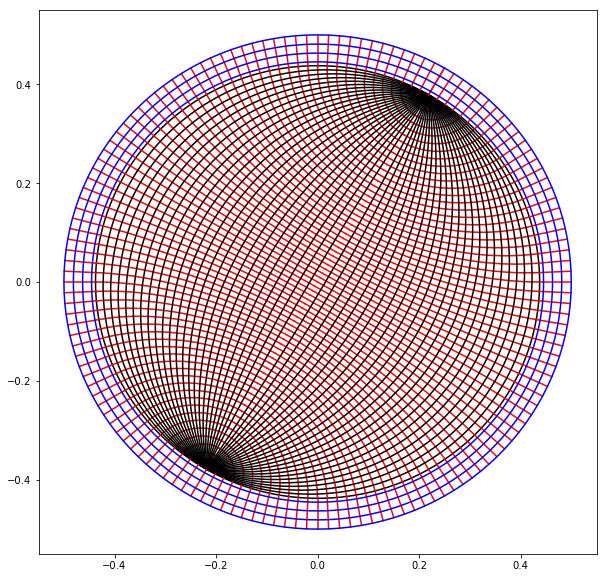

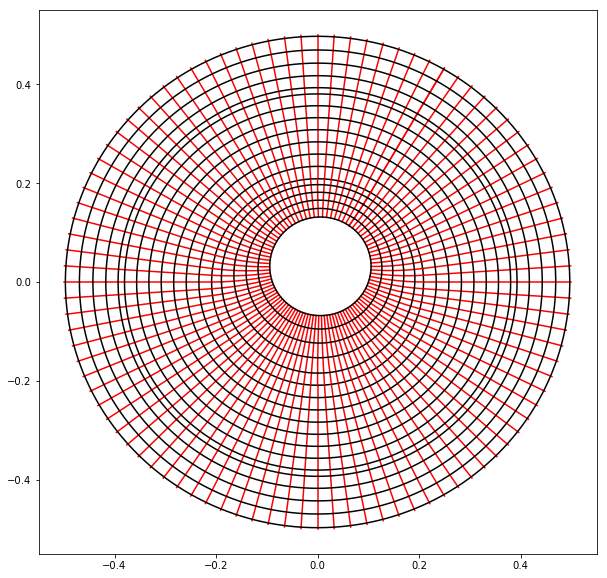

In [5]:
#plot grids
plt.figure(figsize=(10,10))
ogg.plot_mesh_in_xyz(lamBP, phiBP, stride=20,newfig=False)
ogg.plot_mesh_in_xyz(lamMerc,phiMerc, phi_color='b', stride=20,lowerlat=60,newfig=False)

plt.figure(figsize=(10,10))
ogg.plot_mesh_in_xyz(lamSO,phiSO, stride=30,newfig=False)
ogg.plot_mesh_in_xyz(lamSC,phiSC, stride=30,newfig=False)
ogg.plot_mesh_in_xyz(lamMerc,phiMerc, stride=30, upperlat=-60,newfig=False)

### Displaced pole grid

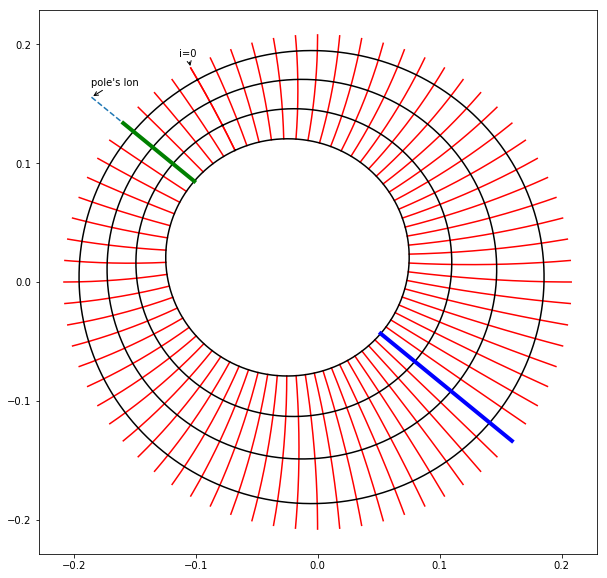

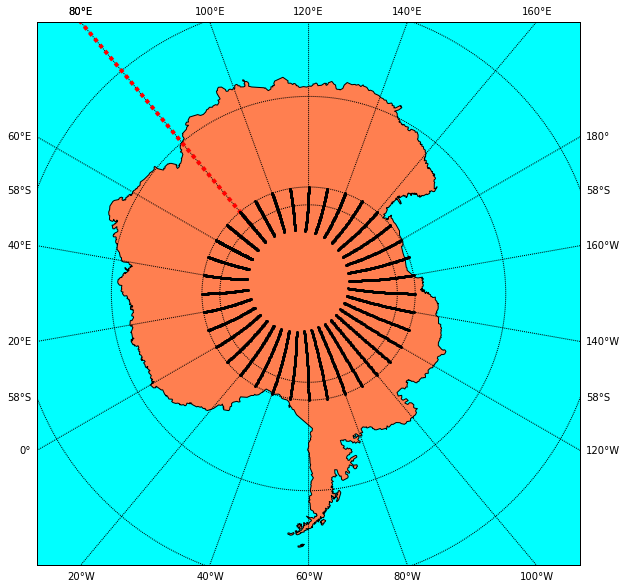

In [6]:
ogg.displacedPoleCap_plot (lamSC,phiSC,lon0,lon_dp,lat0_SO, stride=int(refineR*10),block=True)
ogg.displacedPoleCap_plot2(lamSC,phiSC,lon0,lon_dp,lat0_SO, stride=int(refineR*10),block=True)


### Bipolar cap grid

In [7]:
phiBP.shape

(475, 2881)

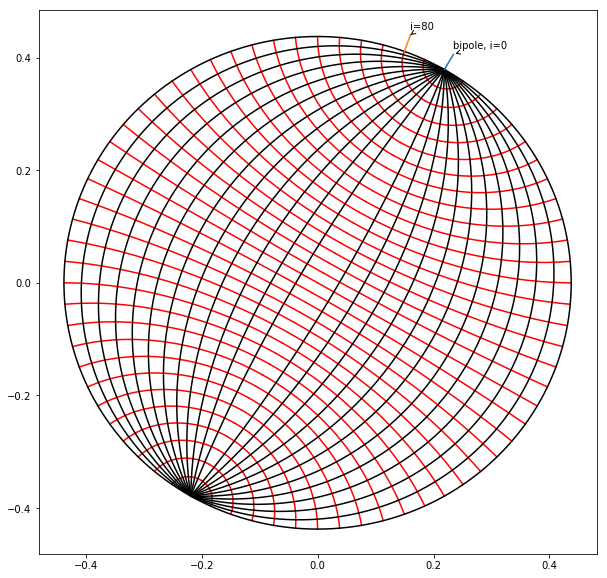

In [8]:
plt.figure(figsize=(10,10))
ogg.plot_mesh_in_xyz(lamBP, phiBP,stride=40)

lam=np.array([lon_bp])
phi=np.array([lat0_bp-2,lat0_bp])
x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
plt.plot(x,y)
plt.annotate("bipole, i=0",xy=(x[0],y[0]), xytext=(x[0],y[0]+0.01),arrowprops=dict(arrowstyle="->"))

iind=80
lam=lamBP[0,80]
phi=np.array([phiBP[0,80]-2,phiBP[0,80]])
x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
plt.plot(x,y)
plt.annotate("i=80",xy=(x[0],y[0]), xytext=(x[0],y[0]+0.01),arrowprops=dict(arrowstyle="->"))


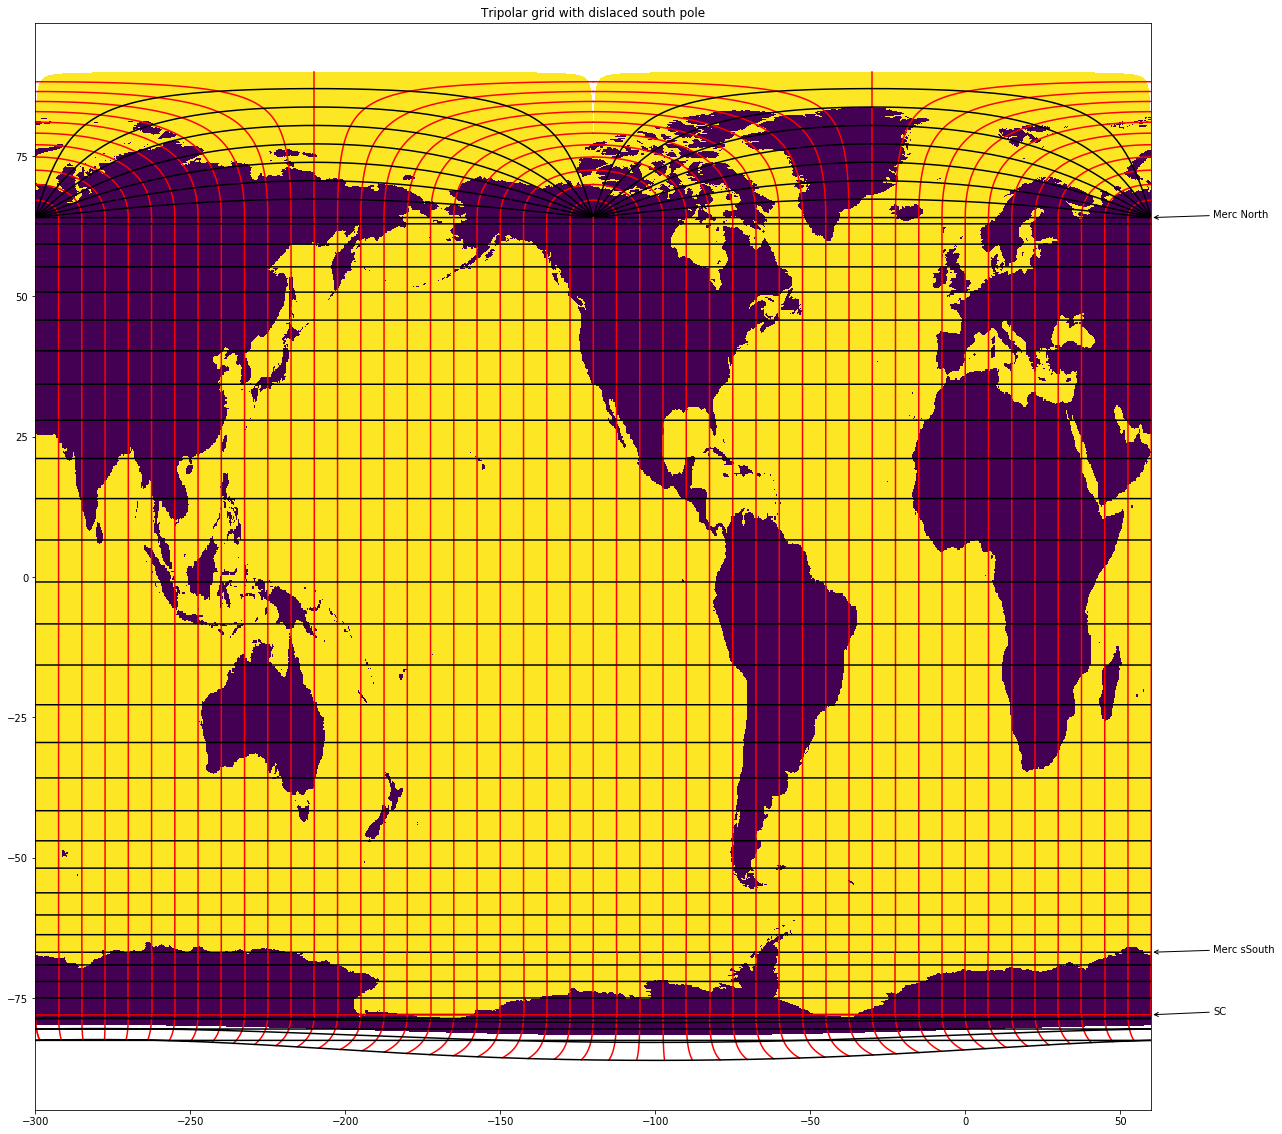

In [10]:
plt.figure(figsize=(20,20))
plt.title("Tripolar grid with dislaced south pole")
ogg.plot_mesh_in_latlon(lamBP, phiBP, stride=60,newfig=False)
ogg.plot_mesh_in_latlon(lamMerc,phiMerc, stride=60,newfig=False);
ogg.plot_mesh_in_latlon(lamSO,phiSO, stride=60,newfig=False)
ogg.plot_mesh_in_latlon(lamSC,phiSC, stride=60,newfig=False)
#plt.arrow(70,-75,10,10)
plt.annotate("Merc North",xy=(60,phi_n_Merc), xytext=(80, phi_n_Merc),arrowprops=dict(arrowstyle="->"))
plt.annotate("Merc sSouth",xy=(60,phi_s_Merc), xytext=(80, phi_s_Merc),arrowprops=dict(arrowstyle="->"))
plt.annotate("SC",xy=(60,lat0_SO), xytext=(80, lat0_SO),arrowprops=dict(arrowstyle="->"))

import netCDF4 as nc
ocean_static = nc.Dataset('/work/Niki.Zadeh/archive/OM4p25_ocean_static.nc')
geolon = np.array(ocean_static.variables['geolon'])
geolat = np.array(ocean_static.variables['geolat'])
wet = np.array(ocean_static.variables['wet'])
plt.pcolormesh(geolon,geolat,wet)